In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [3]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
df = pd.read_csv("Sensex.csv")

In [5]:
df = df.drop(columns=["Unnamed: 0"])

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2773 non-null   datetime64[ns]
 1   value   2773 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.5 KB


In [8]:
df = df.set_index("Date")

In [9]:
df.isnull().sum()

value    0
dtype: int64

In [10]:
df

,value
Date,
2014-05-16,24121.740234
2014-05-19,24363.050781
2014-05-20,24376.880859
2014-05-21,24298.019531
2014-05-22,24374.400391
...,...
2025-08-22,81306.851562
2025-08-25,81635.906250
2025-08-26,80786.539062


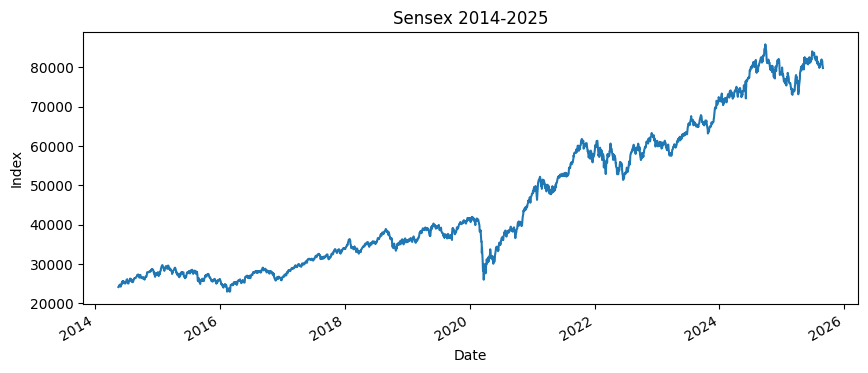

In [12]:
df["value"].plot(figsize=(10,4), title="Sensex 2014-2025", ylabel="Index")
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

values = scaled.flatten()


In [15]:
values

array([0.01860417, 0.02244155, 0.02266148, ..., 0.91970048, 0.90847401,
       0.90416575])

In [16]:
def create_sequences(series, lookback=60):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 60
X, y = create_sequences(values, lookback)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], lookback, 1))


In [18]:
split = int(0.7 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (1899, 60, 1) (1899,)
Test shape: (814, 60, 1) (814,)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)




Epoch 1/50

54/54 [==============================] - 9s 68ms/step - loss: 0.0075 - val_loss: 0.0034
Epoch 2/50
54/54 [==============================] - 2s 45ms/step - loss: 7.0703e-04 - val_loss: 0.0011
Epoch 3/50
54/54 [==============================] - 2s 45ms/step - loss: 5.3718e-04 - val_loss: 0.0023
Epoch 4/50
54/54 [==============================] - 2s 45ms/step - loss: 4.8302e-04 - val_loss: 7.2020e-04
Epoch 5/50
54/54 [==============================] - 2s 44ms/step - loss: 4.5452e-04 - val_loss: 5.3395e-04
Epoch 6/50
54/54 [==============================] - 2s 44ms/step - loss: 4.0808e-04 - val_loss: 4.5488e-04
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 3.7710e-04 - val_loss: 6.5308e-04
Epoch 8/50
54/54 [==============================] - 2s 42ms/step - loss: 3.6665e-04 - val_loss: 4.2556e-04
Epoch 9/50
54/54 [==============================] - 2s 42ms/step - loss: 3.5943e-04 - val_loss: 4.7992e-04
Epoch 10/50
54/54 [==============================]

26/26 [==============================] - 1s 19ms/step


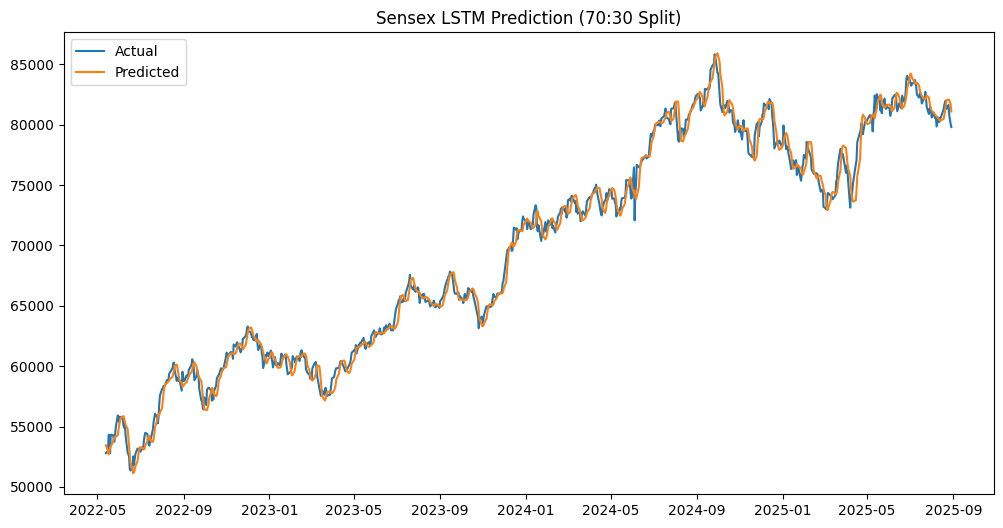

In [20]:
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Actual")
plt.plot(df.index[-len(y_test):], y_pred_inv, label="Predicted")
plt.title("Sensex LSTM Prediction (70:30 Split)")
plt.legend()
plt.show()


In [21]:
future_days = 30  # predict next 30 trading days
last_seq = values[-lookback:]

future_preds = []
curr_seq = last_seq.copy()

for _ in range(future_days):
    X_in = curr_seq.reshape((1, lookback, 1))
    pred = model.predict(X_in, verbose=0)[0][0]
    future_preds.append(pred)
    curr_seq = np.append(curr_seq[1:], pred)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

print("Next 30 days forecast:\n", future_preds_inv.flatten())

Next 30 days forecast:
 [80425.695 80040.766 79822.27  79722.04  79697.695 79717.66  79760.49
 79812.94  79867.58  79920.945 79971.88  80020.484 80067.38  80113.375
 80159.086 80205.03  80251.54  80298.77  80346.78  80395.555 80445.07
 80495.266 80546.04  80597.414 80649.266 80701.6   80754.39  80807.6
 80861.266 80915.32 ]


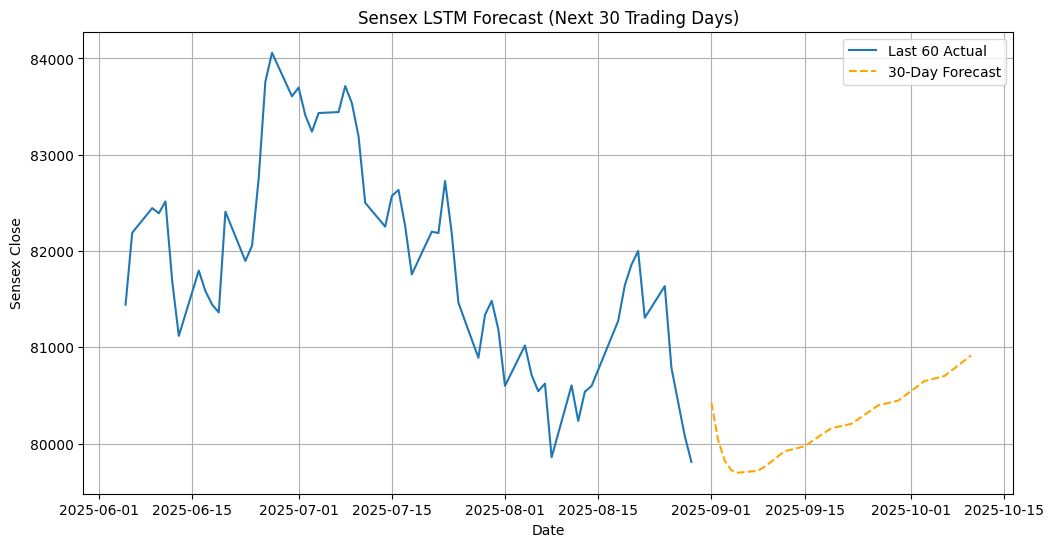

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Get last 60 actual values for context
last_actual = df['value'][-lookback:]

# Create future date index (30 business days after last date in df)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Convert forecast to a pandas series
forecast_series = pd.Series(future_preds_inv.flatten(), index=future_dates)

# Plot
plt.figure(figsize=(12,6))
plt.plot(last_actual.index, last_actual.values, label="Last 60 Actual")
plt.plot(forecast_series.index, forecast_series.values, 
         label="30-Day Forecast", linestyle="--", color="orange")

plt.title("Sensex LSTM Forecast (Next 30 Trading Days)")
plt.xlabel("Date")
plt.ylabel("Sensex Close")
plt.legend()
plt.grid(True)
plt.show()

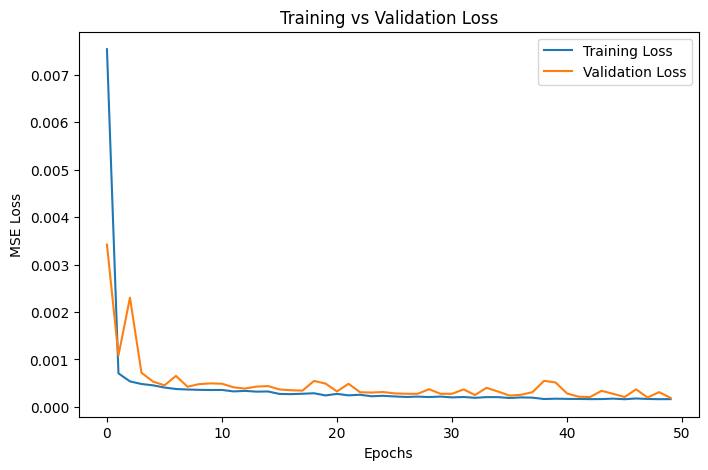

In [29]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


26/26 [==============================] - 1s 18ms/step


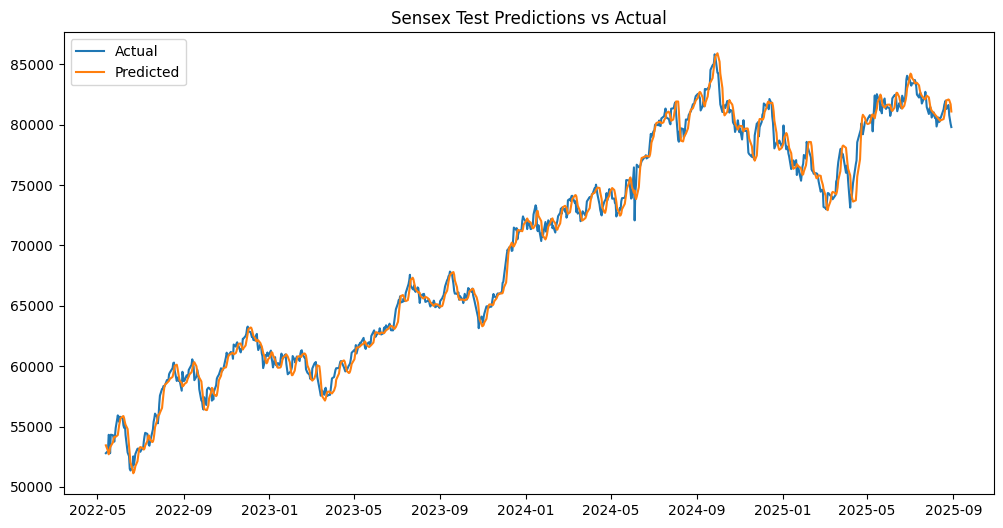

In [30]:
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Actual")
plt.plot(df.index[-len(y_test):], y_pred_inv, label="Predicted")
plt.title("Sensex Test Predictions vs Actual")
plt.legend()
plt.show()


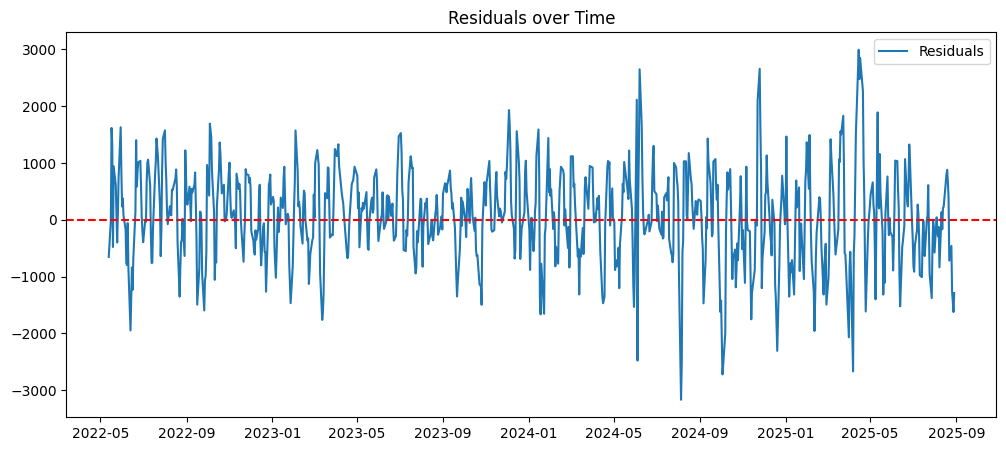

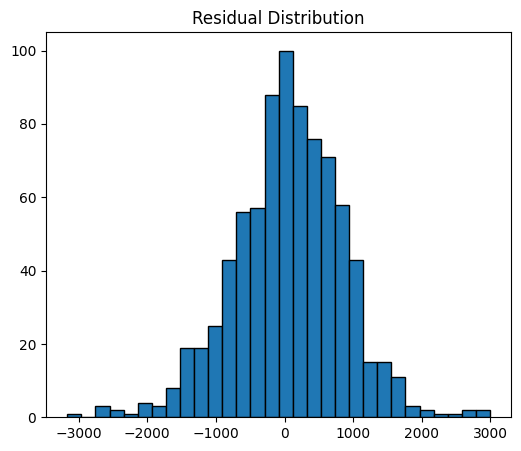

In [31]:
residuals = y_test_inv.flatten() - y_pred_inv.flatten()

plt.figure(figsize=(12,5))
plt.plot(df.index[-len(y_test):], residuals, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals over Time")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Distribution")
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv)/y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")


MAE: 620.10
RMSE: 805.21
MAPE: 0.90%
R²: 0.992


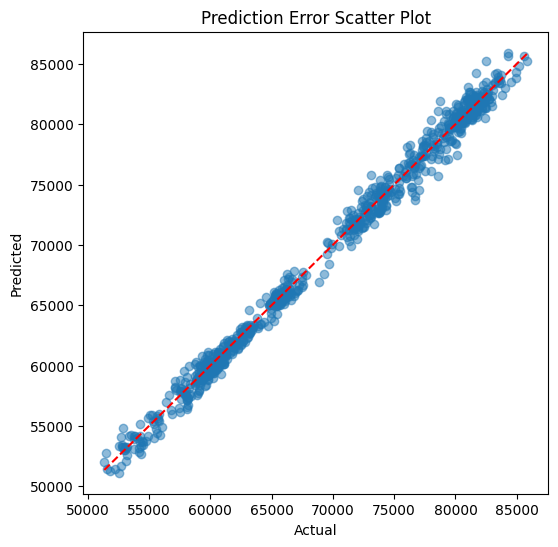

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction Error Scatter Plot")
plt.show()


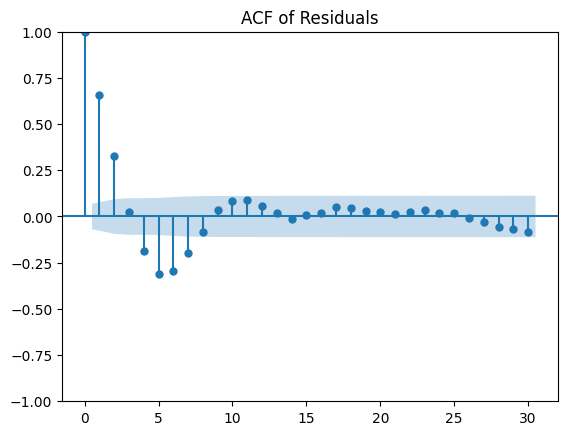

In [34]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()


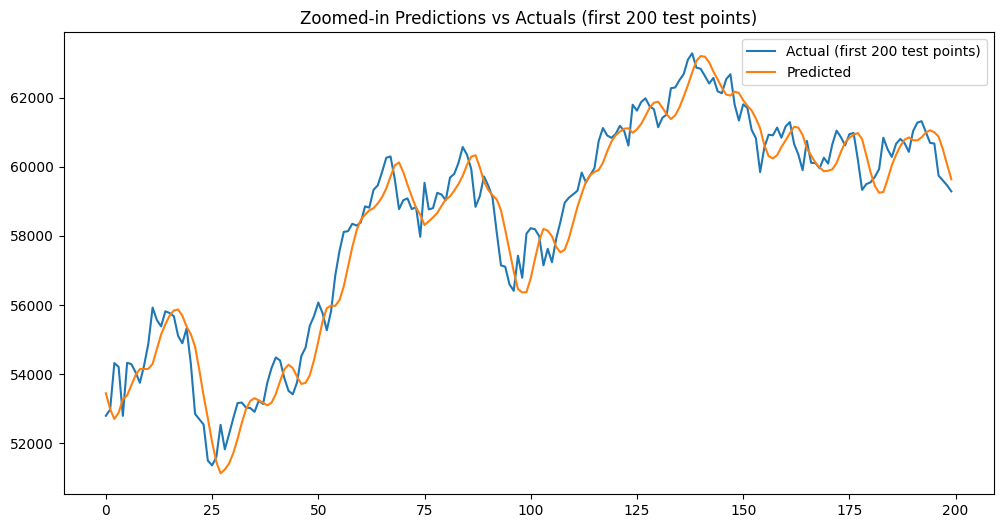

In [35]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200], label="Actual (first 200 test points)")
plt.plot(y_pred_inv[:200], label="Predicted")
plt.title("Zoomed-in Predictions vs Actuals (first 200 test points)")
plt.legend()
plt.show()

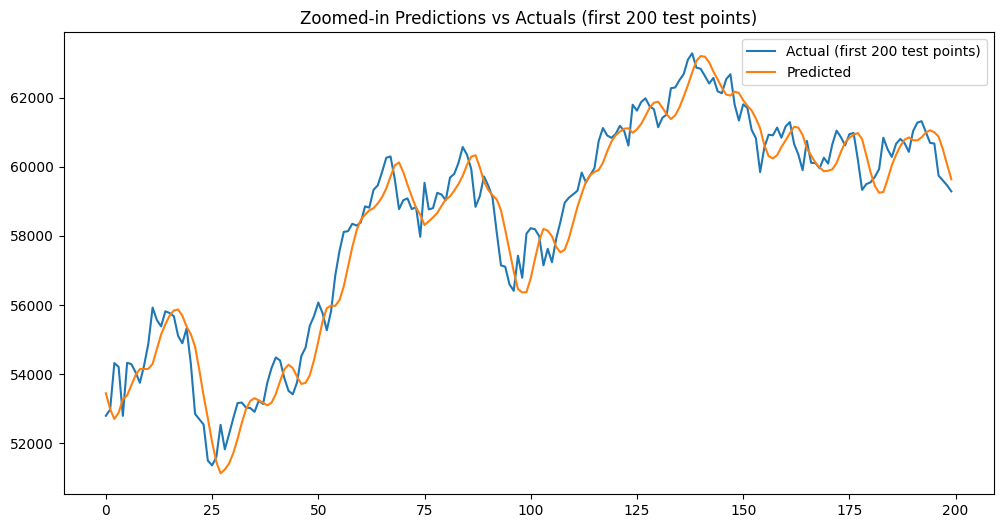

In [36]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200], label="Actual (first 200 test points)")
plt.plot(y_pred_inv[:200], label="Predicted")
plt.title("Zoomed-in Predictions vs Actuals (first 200 test points)")
plt.legend()
plt.show()


In [12]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [13]:
model_arima = auto_arima(train["value"], seasonal=False, trace=True)
forecast_arima = model_arima.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33034.134, Time=4.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33032.254, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33033.958, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33033.961, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33034.165, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33035.961, Time=1.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.986 seconds


D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2218
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -16514.127
Date:                Thu, 11 Sep 2025   AIC                          33032.254
Time:                        19:42:58   BIC                          33043.662
Sample:                             0   HQIC                         33036.421
                               - 2218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.4671      9.113      1.917      0.055      -0.394      35.328
sigma2      1.728e+05   2246.676     76.910      0.000    1.68e+05    1.77e+05
Ljung-Box (L1) (Q):                   0.21   Jarque-

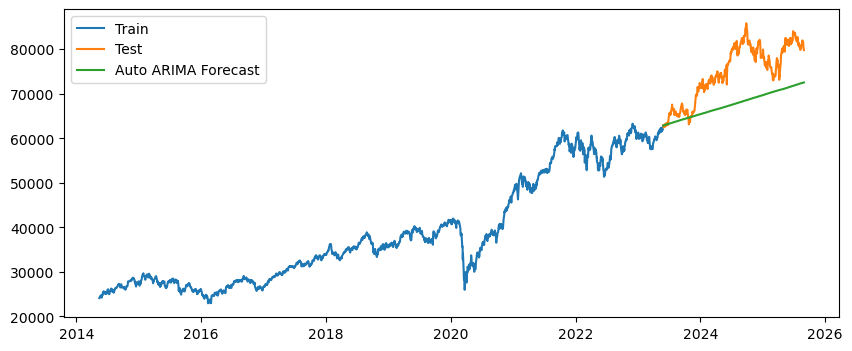

In [15]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train["value"], label="Train")
plt.plot(test.index, test["value"], label="Test")
plt.plot(test.index, forecast_arima, label="Auto ARIMA Forecast")
plt.legend()
plt.show()

In [16]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[["value"]])

In [18]:
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_values)):
    X.append(scaled_values[i-sequence_length:i, 0])
    y.append(scaled_values[i, 0])
X, y = np.array(X), np.array(y)


# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [19]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
model_lstm = Sequential([
LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
LSTM(50),
Dense(1)S
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0084
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.1516e-04
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 3.0341e-04
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.8748e-04
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.7508e-04
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.6221e-04
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.5149e-04
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.3244e-04
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.1829e-04
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.1836e-04
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.0725e-04
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.0140e-04
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.9555e-04
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.0881e-04
Epoch 15/20
68/68 

In [21]:
lstm_pred = model_lstm.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


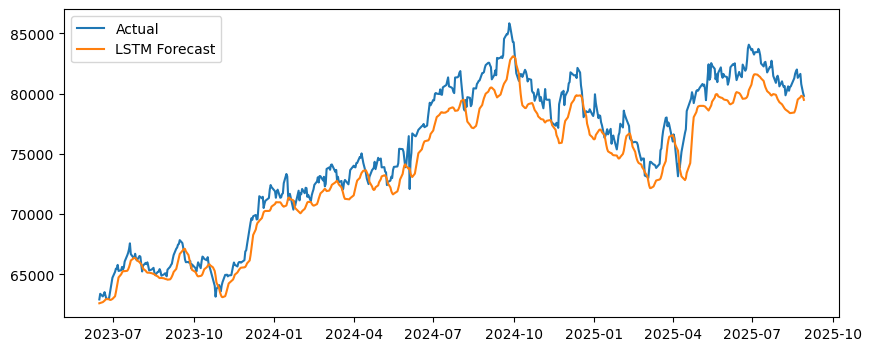

In [22]:
plt.figure(figsize=(10,4))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label="Actual")
plt.plot(df.index[-len(y_test):], lstm_pred_rescaled, label="LSTM Forecast")
plt.legend()
plt.show()

In [23]:
rmse_arima = np.sqrt(mean_squared_error(test["value"], forecast_arima))
print("Auto ARIMA RMSE:", rmse_arima)

Auto ARIMA RMSE: 8298.020628081262


In [24]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, lstm_pred_rescaled))
print("LSTM RMSE:", rmse_lstm)

LSTM RMSE: 1784.8662418496428
